In [26]:
%load_ext autoreload
%autoreload 2
import platform
import os

gdrive = False
linux = True 
# Detect if we're running on a Linux system
linux = platform.system() == "Linux"

# Detect if we're in a Google Colab environment by attempting to import google.colab
try:
    from google.colab import drive
# Mount Google Drive
    drive.mount('/content/drive')
    gdrive=True
except ImportError:
    gdrive = False

# Detect if we're in a Kaggle environment by checking for a Kaggle-specific environment variable
kaggle = "KAGGLE_URL_BASE" in os.environ
environment_flags = {'kaggle': kaggle, 'gdrive': gdrive, 'linux': linux}
print("Environment settings:", environment_flags)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment settings: {'kaggle': False, 'gdrive': False, 'linux': True}


In [27]:
import os
os.chdir('/home/zano/Documents/TESI/FOLDER_CINECA/')
print(os.getcwd())

/home/zano/Documents/TESI/FOLDER_CINECA


## install requirements

## IMPORTS

In [28]:
!python --version   

Python 3.12.3


In [29]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install -r requirementsaaaa.txt

  Using cached pretrained_microscopy_models-0.1.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [31]:
%ls

best_model_fold_0.pth                 notebooks/
best_model_fold_1.pth                 pretrained_encoders/
best_model_fold_2.pth                 README.txt
best_model_fold_3.pth                 requirementsaaaa.txt
best_model_fold_4.pth                 requirements.txt
best_model_fold_5.pth                 simclr_pretraining.py
best_model_fold_6.pth                 simple_image_checker.py
best_model_fold_7.pth                 slurm_files/
byol_simsiam_pretraining.py           snelled_requirements.txt
classes/                              ssl_d121_3c-17253692.out
configs/                              submit_all_3c.sh*
confusion_matrices/                   submit_all_4c.sh*
data/                                 submit_all_pretrained.sh*
downstream_supervised_fine_tuning.py  supervised_learning.py
learning_curves/                      tmp_gradcam/
lightning_logs/                       train_3c.py
logs/                                 train_4c.py
mlflow_ui.log                         trai

In [32]:
# Activate your virtual environment
!source ~/Documents/TESI/FOLDER_CINECA/.venv/bin/activate


In [33]:
import os
import tifffile
import glob
import random
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold
from monai.data import Dataset, DataLoader
# from classes.PrintShapeTransform import PrintShapeTransform
from monai.utils.misc import set_determinism
import monai
print(monai.__version__)
import cv2
#import tifffile
#from monai.networks.nets import DenseNet121
import torch.nn.functional as F
from monai.visualize import GradCAMpp,GradCAM  
import pytorch_lightning
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Import the set_global_seed function or define it if not available
try:
    from utils.reproducibility_functions import set_global_seed
    set_global_seed(42)
except (ImportError, NameError) as e:
    # Define the function locally if import fails
    def set_global_seed(seed):
        """Set seed for all sources of randomness to ensure reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        # Set deterministic behavior for CUDA
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        # Set monai determinism
        set_determinism(seed=seed)
        
    set_global_seed(42)

2.6.0+cu124
1.4.0


## PARAMETERS THAT WILL GET LOGGED ON MLFLOW

In [34]:
import sys
# Add the parent directory to Python path to make configs package accessible
from configs.ConfigLoader import ConfigLoader
sys.path.append(os.path.dirname(os.getcwd()))

yaml_path = "/home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml"
colab_yaml_path = "/content/drive/MyDrive/TESI/FOLDER_CINECA/configs/base.yaml"
try:
    cfg = ConfigLoader(yaml_path)
except ValueError as e:
    print(f"Error loading configuration: {e}")
    print("Please ensure the YAML file contains all required sections.")
    raise

# Set a fixed random seed for reproducibility for all the soruces of randomness
# python, numpy, torch, monai
SEED = 42
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
set_determinism(seed=SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True   # forces deterministic convolution algorithms
cudnn.benchmark     = False  # turn off data-dependent autotune
# monai.utils.set_determinism(seed=SEED)

Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml
Configuration: {'dataset': {'class_names': ['MSA', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 16, 'num_workers': 2}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [32, 32], 'library': 'torchvision'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': False, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_n

# UNIFIED DATA SELECTION

In [46]:
import os

# Define the path for the MLflow tracking directory and its trash folder
mlruns_path = "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
trash_path = os.path.join(mlruns_path, ".trash")

# Create the directories if they don't exist
os.makedirs(trash_path, exist_ok=True)

os.environ["DATA_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA/data"
os.environ["PROJ_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA"
os.environ["MLFLOW_TRACKING_URI"] = f"file:{mlruns_path}"

In [48]:
from utils.directory_functions import get_data_and_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
data_dir, base_dir = get_data_and_base_directory(num_input_channels)
print("data dir:",data_dir)
print("base_dir:",base_dir)

# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri()
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui_locally(tracking_uri) # start mlflow ui

data dir: /home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP
base_dir: /home/zano/Documents/TESI/FOLDER_CINECA
Linux detected, setting tracking URI
Final Tracking URI: file:/home/zano/Documents/TESI/FOLDER_CINECA/mlruns
Does the directory exist? True


In [37]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [38]:
print(f"class_names set to: {class_names}") #chekc if the class names are set correctly

class_names set to: ['MSA', 'PD']


# DATA EXTRACTION

{'MSA': '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/PD'}
MSA images (before filtering): 'gh' count: 104, 'vaso' count: 0
After removing 'vaso', MSA images: 'gh' count: 104, 'vaso' count: 0
PD images (before filtering): 'gh' count: 60, 'vaso' count: 0
After removing 'vaso', PD images: 'gh' count: 60, 'vaso' count: 0


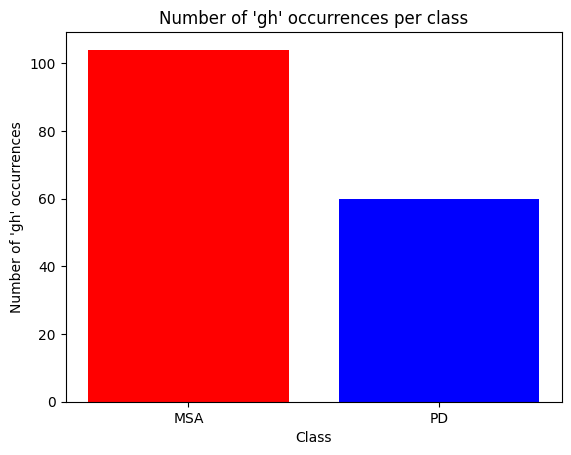


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif  dtype: uint8, 

In [39]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts, key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

## TEST SET SPLIT

In [40]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
# print(cfg.data_splitting["random_seed"])
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size = cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=42
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
print("train images paths:", train_images_paths)
print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths))

train images paths: ['/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_6308.lif - 6308 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_5954 gh2.tif.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_7105.lif - 7105 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_7689.lif - 7689 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_5996 gh.tif.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_6599.lif - 6599 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_7185.lif - 7185 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/3c_MIP/MSA/MAX_6258.lif - 6258 DL VIP red Sinapto gr TH

# SUPERVISED LEARNING


## training augmentations

In [41]:
from configs import ConfigLoader
import utils.transformations_functions as tf
import utils.monai_transformation_functions as mtf
from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
available_models = ["densenet121", "resnet18", "resnet18", "resnet50"]

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/densenet121.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet" or 'imagenet-microscopynet' 
assert pretrained_weights in [None,"microscopynet", "imagenet", "imagenet-microscopynet"], "pretrained_weights must be one of [None, 'microscopynet', 'imagenet', 'imagenet-microscopynet']"
            # indicates that the encoder was first pretrained on imagenet and then finetuned on microscopynet
model_library = "monai" # or "torchvision" or "monai" pretraining dataset, either 'microscopynet' or 
assert model_library in ["torchvision", "monai"], "model_library must be one of ['torchvision', 'monai']"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg, color_transforms=color_transforms)
# train_transforms, val_transforms, test_transforms = mtf.get_transforms(cfg, color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
# print(f"Number of classes in the dataset: {num_classes}")
using_cosine_scheduler = False
# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
# model = model.to(device)  # First, move to the target device
# model = model.float() 
print(model)
# print(cfg.get_model_input_channels())

# if model.__class__.__name__ == "ViT":
#     print("Using ViT hence it requires custom training and validation functions")
#     train_epoch = train_epoch_vit
#     val_epoch = val_epoch_vit

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 7}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

## TRAINING

## NESTED K FOLD WITH HYP(LR) TUNING

This code trains an image classifier using nested cross-validation.
The outer loop evaluates the model's performance, while the inner loop (using Optuna) tunes the learning rate.
For each outer fold, Optuna finds the best learning rate by minimizing validation loss on inner folds.
The model is then retrained on the entire outer training set with this optimal learning rate and evaluated on the outer set. The final results are the average performance metrics across all outer folds. Techniques like oversampling, undersampling, and early stopping are used to improve the model's robustness and generalization.

NB: total number of epoch: n_outer_folds × n_trials × n_inner_folds × inner_num_epochs.

### outer test as test


In [42]:
import pandas as pd
import re
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id) # extract the patient id from the image path and create a new column
display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str) # convert the patient id to a string

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
# create a patient_label_df by filtering df patient_label_df( "patient_id","label")
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first() # group by patient id and take the first label for each patient
display(patient_label_df)

unique_pat_ids = patient_label_df["patient_id"].values  # we need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels     = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

display(patient_label_df)

# Determine the number of classes automatically from the dataset labels
unique_overall_labels = np.unique(labels_np) # Or df['label'].unique()
num_classes = len(unique_overall_labels)
print(f"Detected {num_classes} unique classes: {sorted(unique_overall_labels)}")

# Crucial Check: Ensure labels are 0, 1, ..., N-1 for nn.CrossEntropyLoss
expected_labels = set(range(num_classes)) # set of all possible labels (0...N-1)
actual_labels = set(unique_overall_labels) # set of all actual labels found in labels_np
if expected_labels != actual_labels:
    # Depending on your data, you might raise an error or attempt re-encoding.
    # If labels are e.g., [1, 2, 3], they MUST be mapped to [0, 1, 2].
    raise ValueError(f"Labels must be contiguous integers starting from 0 (i.e., 0 to N-1). Found: {sorted(actual_labels)}")

,image_path,label,patient_id
0,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6599
1,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6008
2,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6008
3,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6179
4,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,1,6791
...,...,...,...
159,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,6657
160,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,7105
161,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,5435
162,/home/zano/Documents/TESI/FOLDER_CINECA/data/3...,0,5969


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
79,7781,1
80,7787,1
81,7811,1
82,7857,0


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6237' '6258' '6308' '6311' '6323' '6326'
 '6337' '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6431'
 '6459' '6485' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663'
 '6690' '6696' '6749' '6773' '6791' '7037' '7056' '7105' '7114' '7120'
 '7132' '7155' '7179' '7185' '7191' '7210' '7229' '7239' '7284' '7293'
 '7318' '7343' '7397' '7407' '7461' '7544' '7579' '7597' '7689' '7781'
 '7787' '7811' '7857' '7893']
Number of unique patients: 84
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 1 0 0 0 1 1 1 0 0]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
79,7781,1
80,7787,1
81,7811,1
82,7857,0


Detected 2 unique classes: [0, 1]


## TRAINING FUNCTIONS

### PRETRAINED IMAGENET

In [43]:
DATA_ROOT  = get_data_directory(num_input_channels)
images, labels = [], []
# get the images and labels from the data directory
for lab, cname in enumerate(class_names):
    for p in (DATA_ROOT / cname).glob("*.tif"):
        if "vaso" in p.name.lower():
            continue
        images.append(str(p)); labels.append(lab)
if len(images) == 0:
    raise FileNotFoundError(f"No images found in {DATA_ROOT}. Check your dataset.")

images, labels = np.array(images), np.array(labels)

tr_imgs, te_imgs, tr_y, te_y = train_test_split(
    images, labels,
    test_size=cfg.get_test_ratio(),
    stratify=labels, random_state=42)

df = pd.DataFrame({"image_path": images,
                    "label": labels,
                    "patient_id": [extract_patient_id(p) for p in images]})
pat_df      = df.groupby("patient_id").first().reset_index()
unique_pats = pat_df["patient_id"].values
pat_labels  = pat_df["label"].values

In [44]:
def best_fold_idx(results, metric="test_balanced_acc") -> int:
    return int(np.argmax([r[metric] for r in results]))

[I 2025-07-16 14:49:45,128] A new study created in memory with name: no-name-8cd4d96c-2476-4969-8492-f599baf53e8b


Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/pretrained/base.yaml
Configuration: {'dataset': {'class_names': ['MSA', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1, 'library': 'monai'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_de

[I 2025-07-16 14:50:08,012] Trial 0 finished with value: 0.7106368839740753 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7106368839740753.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 14:50:30,175] Trial 1 finished with value: 0.9496607879797618 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7106368839740753.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 14:50:52,362] Trial 2 finished with value: 0.7174361646175385 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7106368839740753.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (121,) | X_val_es: (22,)
Early stopping split: Train images: 121, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 0 Epoch 1/125: Tr L: 0.7596, Tr Acc: 0.4740, Val L: 0.7869, Val Acc: 0.4091, Val Bal Acc: 0.5357, Val Roc AUC: 0.6161, Val_mcc: 0.1650, Val F1: 0.5517 lr: 0.000047
 Fold 0 Epoch 2/125: Tr L: 0.6794, Tr Acc: 0.5649, Val L: 0.7073, Val Acc: 0.5000, Val Bal Acc: 0.6071, Val Roc AUC: 0.6607, Val_mcc: 0.3004, Val F1: 0.5926 lr: 0.000047
 Fold 0 Epoch 3/125: Tr L: 0.6455, Tr Acc: 0.5844, Val L: 0.6697, Val Acc: 0.5000, Val Bal Acc: 0.5536, Val Roc AUC: 0.6696, Val_mcc: 0.1107, Val F1: 0.5217 lr: 0.000047
 Fold 0 Epoch 4

[I 2025-07-16 15:01:44,048] A new study created in memory with name: no-name-2d5daf0d-c415-4f7c-a4f8-0165c8d5a7f8



===== OUTER FOLD 2 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 2 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:02:06,036] Trial 0 finished with value: 0.6967304646968842 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6967304646968842.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:02:27,752] Trial 1 finished with value: 1.1526218752066295 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6967304646968842.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:02:49,499] Trial 2 finished with value: 0.7351290384928385 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6967304646968842.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (120,) | X_val_es: (22,)
Early stopping split: Train images: 120, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 1 Epoch 1/125: Tr L: 0.7307, Tr Acc: 0.4934, Val L: 0.8579, Val Acc: 0.3636, Val Bal Acc: 0.5000, Val Roc AUC: 0.5536, Val_mcc: 0.0000, Val F1: 0.5333 lr: 0.000047
 Fold 1 Epoch 2/125: Tr L: 0.6595, Tr Acc: 0.5987, Val L: 0.7610, Val Acc: 0.4545, Val Bal Acc: 0.5714, Val Roc AUC: 0.6607, Val_mcc: 0.2390, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 3/125: Tr L: 0.6087, Tr Acc: 0.6842, Val L: 0.6981, Val Acc: 0.6818, Val Bal Acc: 0.7232, Val Roc AUC: 0.7054, Val_mcc: 0.4368, Val F1: 0.6667 lr: 0.000047
 Fold 1 Epoch 4

[I 2025-07-16 15:08:20,801] A new study created in memory with name: no-name-e189f18d-414f-4ce8-a2a2-f3065aced266



===== OUTER FOLD 3 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 3 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:08:42,997] Trial 0 finished with value: 0.6964853405952454 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6964853405952454.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:09:05,030] Trial 1 finished with value: 0.9333692267537117 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6964853405952454.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:09:27,091] Trial 2 finished with value: 0.7115181287129719 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6964853405952454.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (121,) | X_val_es: (22,)
Early stopping split: Train images: 121, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 2 Epoch 1/125: Tr L: 0.7196, Tr Acc: 0.5455, Val L: 0.7727, Val Acc: 0.4545, Val Bal Acc: 0.5714, Val Roc AUC: 0.6161, Val_mcc: 0.2390, Val F1: 0.5714 lr: 0.000047
 Fold 2 Epoch 2/125: Tr L: 0.6422, Tr Acc: 0.6558, Val L: 0.7043, Val Acc: 0.5909, Val Bal Acc: 0.6518, Val Roc AUC: 0.6875, Val_mcc: 0.3135, Val F1: 0.6087 lr: 0.000047
 Fold 2 Epoch 3/125: Tr L: 0.5867, Tr Acc: 0.6818, Val L: 0.6699, Val Acc: 0.6364, Val Bal Acc: 0.6875, Val Roc AUC: 0.6429, Val_mcc: 0.3750, Val F1: 0.6364 lr: 0.000047
 Fold 2 Epoch 4

[I 2025-07-16 15:14:38,654] A new study created in memory with name: no-name-236c70a2-2654-483c-a21b-dd677b5397b3



===== OUTER FOLD 4 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 4 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:15:01,006] Trial 0 finished with value: 0.69625390569369 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.69625390569369.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:15:23,169] Trial 1 finished with value: 0.8081077386935551 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.69625390569369.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:15:45,289] Trial 2 finished with value: 0.6729472974936167 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6729472974936167.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 4 with LR=0.000401 ---
X_train_es: (120,) | X_val_es: (22,)
Early stopping split: Train images: 120, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 3 Epoch 1/125: Tr L: 0.6341, Tr Acc: 0.6316, Val L: 0.6568, Val Acc: 0.5909, Val Bal Acc: 0.5982, Val Roc AUC: 0.6071, Val_mcc: 0.1890, Val F1: 0.5263 lr: 0.000401
 Fold 3 Epoch 2/125: Tr L: 0.5245, Tr Acc: 0.7632, Val L: 0.5973, Val Acc: 0.6364, Val Bal Acc: 0.5804, Val Roc AUC: 0.7232, Val_mcc: 0.1736, Val F1: 0.4286 lr: 0.000401
 Fold 3 Epoch 3/125: Tr L: 0.3057, Tr Acc: 0.9079, Val L: 0.8379, Val Acc: 0.5909, Val Bal Acc: 0.6518, Val Roc AUC: 0.7143, Val_mcc: 0.3135, Val F1: 0.6087 lr: 0.000401
 Fold 3 Epoch 4

[I 2025-07-16 15:19:24,825] A new study created in memory with name: no-name-8c24d1c7-72e2-4576-945b-bbdfa5e5a8b1



===== OUTER FOLD 5 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 5 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:19:47,492] Trial 0 finished with value: 0.7004726231098175 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7004726231098175.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:20:09,932] Trial 1 finished with value: 0.8757992163300514 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7004726231098175.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:20:32,385] Trial 2 finished with value: 0.7487478454907734 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7004726231098175.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 4 Epoch 1/125: Tr L: 0.7161, Tr Acc: 0.5263, Val L: 0.8222, Val Acc: 0.4545, Val Bal Acc: 0.5714, Val Roc AUC: 0.4196, Val_mcc: 0.2390, Val F1: 0.5714 lr: 0.000047
 Fold 4 Epoch 2/125: Tr L: 0.6554, Tr Acc: 0.5987, Val L: 0.7689, Val Acc: 0.4545, Val Bal Acc: 0.5446, Val Roc AUC: 0.4911, Val_mcc: 0.1114, Val F1: 0.5385 lr: 0.000047
 Fold 4 Epoch 3/125: Tr L: 0.6147, Tr Acc: 0.6908, Val L: 0.7466, Val Acc: 0.5455, Val Bal Acc: 0.5625, Val Roc AUC: 0.5357, Val_mcc: 0.1208, Val F1: 0.5000 lr: 0.000047
 Fold 4 Epoch 4

[I 2025-07-16 15:29:20,928] A new study created in memory with name: no-name-310b25f2-dc3e-4f6f-b876-684da14132b8



===== OUTER FOLD 6 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 6 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:29:42,802] Trial 0 finished with value: 0.681040088335673 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.681040088335673.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:30:04,693] Trial 1 finished with value: 0.9635903810461361 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.681040088335673.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:30:26,660] Trial 2 finished with value: 0.7147121727466583 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.681040088335673.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 5 Epoch 1/125: Tr L: 0.7522, Tr Acc: 0.4934, Val L: 0.8160, Val Acc: 0.4545, Val Bal Acc: 0.5714, Val Roc AUC: 0.5446, Val_mcc: 0.2390, Val F1: 0.5714 lr: 0.000047
 Fold 5 Epoch 2/125: Tr L: 0.6791, Tr Acc: 0.5789, Val L: 0.7258, Val Acc: 0.5000, Val Bal Acc: 0.5804, Val Roc AUC: 0.6161, Val_mcc: 0.1845, Val F1: 0.5600 lr: 0.000047
 Fold 5 Epoch 3/125: Tr L: 0.6486, Tr Acc: 0.6645, Val L: 0.7092, Val Acc: 0.5909, Val Bal Acc: 0.6250, Val Roc AUC: 0.5804, Val_mcc: 0.2446, Val F1: 0.5714 lr: 0.000047
 Fold 5 Epoch 4

[I 2025-07-16 15:34:22,607] A new study created in memory with name: no-name-70bb9450-d70d-43d2-95f6-76a32511d636



===== OUTER FOLD 7 / 8 =====
Outer Train images: 146 | Outer Test images: 18
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 7 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:34:46,375] Trial 0 finished with value: 0.696690614024798 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.696690614024798.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:35:09,767] Trial 1 finished with value: 0.8107650776704152 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.696690614024798.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:35:33,129] Trial 2 finished with value: 0.69070369998614 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.69070369998614.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 7 with LR=0.000401 ---
X_train_es: (124,) | X_val_es: (22,)
Early stopping split: Train images: 124, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 6 Epoch 1/125: Tr L: 0.6250, Tr Acc: 0.6125, Val L: 0.7695, Val Acc: 0.4545, Val Bal Acc: 0.5446, Val Roc AUC: 0.7143, Val_mcc: 0.1114, Val F1: 0.5385 lr: 0.000401
 Fold 6 Epoch 2/125: Tr L: 0.4241, Tr Acc: 0.7875, Val L: 0.7581, Val Acc: 0.6364, Val Bal Acc: 0.6875, Val Roc AUC: 0.6875, Val_mcc: 0.3750, Val F1: 0.6364 lr: 0.000401
 Fold 6 Epoch 3/125: Tr L: 0.2883, Tr Acc: 0.8750, Val L: 0.8401, Val Acc: 0.5909, Val Bal Acc: 0.6518, Val Roc AUC: 0.7054, Val_mcc: 0.3135, Val F1: 0.6087 lr: 0.000401
 Fold 6 Epoch 4

[I 2025-07-16 15:39:42,358] A new study created in memory with name: no-name-9ec80295-35a1-4343-a015-598830ef1466



===== OUTER FOLD 8 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 8 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 15:40:05,161] Trial 0 finished with value: 0.6951141854127248 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6951141854127248.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:40:27,756] Trial 1 finished with value: 1.4186303205788136 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6951141854127248.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263


[I 2025-07-16 15:40:50,570] Trial 2 finished with value: 0.7419175753990809 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6951141854127248.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 8 with LR=0.000047 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet121...
Freezing layers up to index: 263
Model Architecture:
Total parameters: 6,955,906
Trainable parameters: 2,162,178
Non-trainable parameters: 4,793,728
 Fold 7 Epoch 1/125: Tr L: 0.7310, Tr Acc: 0.5128, Val L: 0.8261, Val Acc: 0.4545, Val Bal Acc: 0.5714, Val Roc AUC: 0.4821, Val_mcc: 0.2390, Val F1: 0.5714 lr: 0.000047
 Fold 7 Epoch 2/125: Tr L: 0.6528, Tr Acc: 0.6282, Val L: 0.7190, Val Acc: 0.5455, Val Bal Acc: 0.5893, Val Roc AUC: 0.6161, Val_mcc: 0.1786, Val F1: 0.5455 lr: 0.000047
 Fold 7 Epoch 3/125: Tr L: 0.6082, Tr Acc: 0.6667, Val L: 0.6829, Val Acc: 0.5909, Val Bal Acc: 0.6250, Val Roc AUC: 0.5804, Val_mcc: 0.2446, Val F1: 0.5714 lr: 0.000047
 Fold 7 Epoch 4

2025/07/16 15:52:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp07tax3vp/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/07/16 15:52:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Processing batch 1, shape: torch.Size([25, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet121_oversamp_TL_pretrained:imagenet_freeze:263_torchvision_color_transforms:False_07-16_at:15-52-04/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet121_oversamp_TL_pretrained:imagenet_freeze:263_torchvision_color_transforms:False_07-16_at:15-52-04/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet121_oversamp_TL_pretrained:imagenet_freeze:263_torchvision_color_transforms:False_07-16_at:15-52-04/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet121_oversamp_TL_pretrained:imagenet_freeze:263_torchvision_color_transfor

[I 2025-07-16 15:52:17,460] A new study created in memory with name: no-name-905f4f5e-6488-4973-abf8-4fc907734d06


Detected 2 unique classes.

===== OUTER FOLD 1 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 1 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchv

[I 2025-07-16 15:52:42,620] Trial 0 finished with value: 0.7133710384368896 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7133710384368896.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 15:53:07,180] Trial 1 finished with value: 1.2877855971455574 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7133710384368896.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 15:53:31,521] Trial 2 finished with value: 0.7450133015712102 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7133710384368896.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (121,) | X_val_es: (22,)
Early stopping split: Train images: 121, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 0 Epoch 1/125: Tr L: 0.6943, Tr Acc: 0.5455, Val L: 0.6777, Val Acc: 0.5455, Val Bal Acc: 0.5625, Val Roc AUC: 0.5982, Val_mcc: 0.1208, Val F1: 0.5000 lr: 0.000047
 Fold 0 Epoch 2/125: Tr L: 0.5901, Tr Acc: 0.7208, Val L: 0.6826, Val Acc: 0.5909, Val Bal Acc: 0.6250, Val Roc AUC: 0.6071, Val_mcc: 0.2446, Val F1: 0.5714 lr: 0.000047
 Fold 0 Epoch 3/125: Tr L: 0.5219, Tr Acc: 0.8377, Val L: 0.6504, Val Acc: 0.6364, Val Bal Acc: 0.6607, Val Roc AUC: 0.6964, Val_mcc: 0.3105, Val F1: 0.6000 lr: 0.000047
 Fold 0 Epoch 

[I 2025-07-16 16:00:39,800] A new study created in memory with name: no-name-cc207364-a544-4972-abee-0ac99105664e



===== OUTER FOLD 2 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 2 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:01:04,414] Trial 0 finished with value: 0.7129729290803273 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7129729290803273.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:01:29,656] Trial 1 finished with value: 0.9233978142340977 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7129729290803273.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:01:54,365] Trial 2 finished with value: 0.7096527864535649 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7096527864535649.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 2 with LR=0.000401 ---
X_train_es: (120,) | X_val_es: (22,)
Early stopping split: Train images: 120, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 1 Epoch 1/125: Tr L: 0.5934, Tr Acc: 0.6382, Val L: 1.2000, Val Acc: 0.3636, Val Bal Acc: 0.5000, Val Roc AUC: 0.6964, Val_mcc: 0.0000, Val F1: 0.5333 lr: 0.000401
 Fold 1 Epoch 2/125: Tr L: 0.4459, Tr Acc: 0.7961, Val L: 0.6478, Val Acc: 0.7273, Val Bal Acc: 0.7857, Val Roc AUC: 0.8304, Val_mcc: 0.5714, Val F1: 0.7273 lr: 0.000401
 Fold 1 Epoch 3/125: Tr L: 0.2901, Tr Acc: 0.8487, Val L: 0.8327, Val Acc: 0.7727, Val Bal Acc: 0.8214, Val Roc AUC: 0.8125, Val_mcc: 0.6290, Val F1: 0.7619 lr: 0.000401
 Fold 1 Epoch 

[I 2025-07-16 16:06:15,634] A new study created in memory with name: no-name-7d65b27a-a544-4727-89b7-87f5f7505c44



===== OUTER FOLD 3 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 3 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:06:40,759] Trial 0 finished with value: 0.7201253275076549 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7201253275076549.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:07:05,901] Trial 1 finished with value: 1.7262907430219154 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7201253275076549.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:07:30,992] Trial 2 finished with value: 0.6194452991088232 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6194452991088232.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (121,) | X_val_es: (22,)
Early stopping split: Train images: 121, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 2 Epoch 1/125: Tr L: 0.6343, Tr Acc: 0.6039, Val L: 0.7842, Val Acc: 0.4091, Val Bal Acc: 0.4821, Val Roc AUC: 0.5714, Val_mcc: -0.0410, Val F1: 0.4800 lr: 0.000401
 Fold 2 Epoch 2/125: Tr L: 0.2593, Tr Acc: 0.9156, Val L: 0.8507, Val Acc: 0.5455, Val Bal Acc: 0.5357, Val Roc AUC: 0.5982, Val_mcc: 0.0690, Val F1: 0.4444 lr: 0.000401
 Fold 2 Epoch 3/125: Tr L: 0.2252, Tr Acc: 0.9026, Val L: 1.0137, Val Acc: 0.6818, Val Bal Acc: 0.6696, Val Roc AUC: 0.7321, Val_mcc: 0.3320, Val F1: 0.5882 lr: 0.000401
 Fold 2 Epoch

[I 2025-07-16 16:11:34,215] A new study created in memory with name: no-name-64d15492-84ef-46f7-a91a-ce87d35d6c9f



===== OUTER FOLD 4 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 4 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:11:59,058] Trial 0 finished with value: 0.680461585521698 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.680461585521698.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:12:23,895] Trial 1 finished with value: 1.886740409148236 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.680461585521698.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:12:48,730] Trial 2 finished with value: 0.6771138856808345 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6771138856808345.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 4 with LR=0.000401 ---
X_train_es: (120,) | X_val_es: (22,)
Early stopping split: Train images: 120, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 3 Epoch 1/125: Tr L: 0.6344, Tr Acc: 0.6316, Val L: 0.8514, Val Acc: 0.3636, Val Bal Acc: 0.4464, Val Roc AUC: 0.5179, Val_mcc: -0.1336, Val F1: 0.4615 lr: 0.000401
 Fold 3 Epoch 2/125: Tr L: 0.4671, Tr Acc: 0.7368, Val L: 0.7803, Val Acc: 0.5455, Val Bal Acc: 0.5893, Val Roc AUC: 0.6339, Val_mcc: 0.1786, Val F1: 0.5455 lr: 0.000401
 Fold 3 Epoch 3/125: Tr L: 0.2082, Tr Acc: 0.9276, Val L: 1.3756, Val Acc: 0.4091, Val Bal Acc: 0.5089, Val Roc AUC: 0.6964, Val_mcc: 0.0250, Val F1: 0.5185 lr: 0.000401
 Fold 3 Epoch

[I 2025-07-16 16:18:28,248] A new study created in memory with name: no-name-ea2f2577-b8f9-4152-8653-13741c6e219e



===== OUTER FOLD 5 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 5 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:18:53,103] Trial 0 finished with value: 0.7349719107151031 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7349719107151031.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:19:17,791] Trial 1 finished with value: 1.0548797498146694 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7349719107151031.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:19:42,286] Trial 2 finished with value: 0.7245377600193024 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7245377600193024.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 5 with LR=0.000401 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 4 Epoch 1/125: Tr L: 0.6151, Tr Acc: 0.6250, Val L: 0.8584, Val Acc: 0.4091, Val Bal Acc: 0.5357, Val Roc AUC: 0.5625, Val_mcc: 0.1650, Val F1: 0.5517 lr: 0.000401
 Fold 4 Epoch 2/125: Tr L: 0.4130, Tr Acc: 0.7961, Val L: 0.7659, Val Acc: 0.4545, Val Bal Acc: 0.5179, Val Roc AUC: 0.5982, Val_mcc: 0.0386, Val F1: 0.5000 lr: 0.000401
 Fold 4 Epoch 3/125: Tr L: 0.2387, Tr Acc: 0.9079, Val L: 1.2663, Val Acc: 0.5000, Val Bal Acc: 0.5804, Val Roc AUC: 0.6429, Val_mcc: 0.1845, Val F1: 0.5600 lr: 0.000401
 Fold 4 Epoch 

[I 2025-07-16 16:23:44,631] A new study created in memory with name: no-name-efd81e7c-574f-4b69-b23f-1558317406a6



===== OUTER FOLD 6 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 6 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:24:09,010] Trial 0 finished with value: 0.7362708151340485 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7362708151340485.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:24:33,393] Trial 1 finished with value: 0.8723134398460388 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7362708151340485.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:24:57,667] Trial 2 finished with value: 0.7137775123119354 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7137775123119354.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 6 with LR=0.000401 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 5 Epoch 1/125: Tr L: 0.5528, Tr Acc: 0.6645, Val L: 0.7977, Val Acc: 0.5000, Val Bal Acc: 0.5536, Val Roc AUC: 0.5179, Val_mcc: 0.1107, Val F1: 0.5217 lr: 0.000401
 Fold 5 Epoch 2/125: Tr L: 0.3983, Tr Acc: 0.8487, Val L: 0.8923, Val Acc: 0.5455, Val Bal Acc: 0.5089, Val Roc AUC: 0.5089, Val_mcc: 0.0179, Val F1: 0.3750 lr: 0.000401
 Fold 5 Epoch 3/125: Tr L: 0.2649, Tr Acc: 0.8750, Val L: 1.3710, Val Acc: 0.5909, Val Bal Acc: 0.4911, Val Roc AUC: 0.4732, Val_mcc: -0.0250, Val F1: 0.1818 lr: 0.000401
 Fold 5 Epoch

[I 2025-07-16 16:28:56,201] A new study created in memory with name: no-name-654fd9fd-b6ac-4258-96f5-aa1b3ef72329



===== OUTER FOLD 7 / 8 =====
Outer Train images: 146 | Outer Test images: 18
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 7 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:29:22,476] Trial 0 finished with value: 0.7099560995896657 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7099560995896657.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:29:49,158] Trial 1 finished with value: 2.168976294332727 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7099560995896657.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:30:15,385] Trial 2 finished with value: 0.843284750978152 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7099560995896657.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 7 with LR=0.000047 ---
X_train_es: (124,) | X_val_es: (22,)
Early stopping split: Train images: 124, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 6 Epoch 1/125: Tr L: 0.6891, Tr Acc: 0.5750, Val L: 0.6770, Val Acc: 0.5455, Val Bal Acc: 0.5625, Val Roc AUC: 0.5982, Val_mcc: 0.1208, Val F1: 0.5000 lr: 0.000047
 Fold 6 Epoch 2/125: Tr L: 0.5748, Tr Acc: 0.7312, Val L: 0.6821, Val Acc: 0.6364, Val Bal Acc: 0.6875, Val Roc AUC: 0.5625, Val_mcc: 0.3750, Val F1: 0.6364 lr: 0.000047
 Fold 6 Epoch 3/125: Tr L: 0.4783, Tr Acc: 0.8313, Val L: 0.6442, Val Acc: 0.6364, Val Bal Acc: 0.6875, Val Roc AUC: 0.7232, Val_mcc: 0.3750, Val F1: 0.6364 lr: 0.000047
 Fold 6 Epoch 

[I 2025-07-16 16:35:14,048] A new study created in memory with name: no-name-36ef5aaa-6b03-4e5a-b3f1-4a6fccf62a4b



===== OUTER FOLD 8 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 8 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:35:39,510] Trial 0 finished with value: 0.7242034077644348 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7242034077644348.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:36:04,941] Trial 1 finished with value: 1.1746802429358163 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7242034077644348.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308


[I 2025-07-16 16:36:30,342] Trial 2 finished with value: 0.7227608660856883 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.7227608660856883.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 8 with LR=0.000401 ---
X_train_es: (122,) | X_val_es: (22,)
Early stopping split: Train images: 122, Validation images: 22
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision DenseNet169...
Freezing layers up to index: 308
Model Architecture:
Total parameters: 12,487,810
Trainable parameters: 6,742,018
Non-trainable parameters: 5,745,792
 Fold 7 Epoch 1/125: Tr L: 0.6031, Tr Acc: 0.6474, Val L: 0.8115, Val Acc: 0.5000, Val Bal Acc: 0.5536, Val Roc AUC: 0.6339, Val_mcc: 0.1107, Val F1: 0.5217 lr: 0.000401
 Fold 7 Epoch 2/125: Tr L: 0.3672, Tr Acc: 0.8333, Val L: 0.7728, Val Acc: 0.6818, Val Bal Acc: 0.6964, Val Roc AUC: 0.6964, Val_mcc: 0.3780, Val F1: 0.6316 lr: 0.000401
 Fold 7 Epoch 3/125: Tr L: 0.2205, Tr Acc: 0.9167, Val L: 0.9664, Val Acc: 0.5455, Val Bal Acc: 0.5625, Val Roc AUC: 0.7232, Val_mcc: 0.1208, Val F1: 0.5000 lr: 0.000401
 Fold 7 Epoch 

2025/07/16 16:41:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpggz_4cja/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/07/16 16:41:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Processing batch 1, shape: torch.Size([25, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet169_oversamp_TL_pretrained:imagenet_freeze:308_torchvision_color_transforms:False_07-16_at:16-41-01/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet169_oversamp_TL_pretrained:imagenet_freeze:308_torchvision_color_transforms:False_07-16_at:16-41-01/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet169_oversamp_TL_pretrained:imagenet_freeze:308_torchvision_color_transforms:False_07-16_at:16-41-01/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet169_oversamp_TL_pretrained:imagenet_freeze:308_torchvision_color_transfor

[I 2025-07-16 16:41:15,225] A new study created in memory with name: no-name-eee2df35-7263-4c1a-82c9-6824f7a37948


Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Densenet169_oversamp_TL_pretrained:imagenet_freeze:308_torchvision_color_transforms:False_07-16_at:16-41-01/batch_0_img_24.png
Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/pretrained/base.yaml
Configuration: {'dataset': {'class_names': ['MSA', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1, 'library': 'monai'}, 'training': {'num_epochs': 50, 'early_stopping_pati

[I 2025-07-16 16:41:41,662] Trial 0 finished with value: 0.7067619313796362 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7067619313796362.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 16:42:07,854] Trial 1 finished with value: 2.4749840895334883 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7067619313796362.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 16:42:34,156] Trial 2 finished with value: 0.8099178473154703 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7067619313796362.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (118,) | X_val_es: (25,)
Early stopping split: Train images: 118, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 0 Epoch 1/200: Tr L: 0.6947, Tr Acc: 0.5533, Val L: 0.7773, Val Acc: 0.4000, Val Bal Acc: 0.4826, Val Roc AUC: 0.5556, Val_mcc: -0.0417, Val F1: 0.4828 lr: 0.000047
 Fold 0 Epoch 2/200: Tr L: 0.6422, Tr Acc: 0.6467, Val L: 0.7416, Val Acc: 0.4000, Val Bal Acc: 0.4826, Val Roc AUC: 0.5694, Val_mcc: -0.0417, Val F1: 0.4828 lr: 0.000047
 Fold 0 Epoch 3/200: Tr L: 0.5615, Tr Acc: 0.7667, Val L: 0.6657, Val Acc: 0.6400, Val Bal Acc: 0.6458, Val Roc AUC: 0.6250, Val_mcc: 0.2802, Val F1: 0.5714 lr: 0.000047
 Fold 0 Epoch 4/

[I 2025-07-16 16:52:17,697] A new study created in memory with name: no-name-9838d589-85ca-46a8-a442-4b07db35d81c



===== OUTER FOLD 2 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 2 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 16:52:43,912] Trial 0 finished with value: 0.680057500799497 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.680057500799497.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 16:53:09,904] Trial 1 finished with value: 3.2621150302390256 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.680057500799497.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 16:53:35,409] Trial 2 finished with value: 0.7382180988788605 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.680057500799497.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (117,) | X_val_es: (25,)
Early stopping split: Train images: 117, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 1 Epoch 1/200: Tr L: 0.7023, Tr Acc: 0.5878, Val L: 0.8129, Val Acc: 0.3200, Val Bal Acc: 0.3958, Val Roc AUC: 0.3958, Val_mcc: -0.2500, Val F1: 0.4138 lr: 0.000047
 Fold 1 Epoch 2/200: Tr L: 0.6010, Tr Acc: 0.6892, Val L: 0.8189, Val Acc: 0.3600, Val Bal Acc: 0.4757, Val Roc AUC: 0.5833, Val_mcc: -0.0860, Val F1: 0.5000 lr: 0.000047
 Fold 1 Epoch 3/200: Tr L: 0.5268, Tr Acc: 0.7838, Val L: 0.7474, Val Acc: 0.5200, Val Bal Acc: 0.6007, Val Roc AUC: 0.7153, Val_mcc: 0.2263, Val F1: 0.5714 lr: 0.000047
 Fold 1 Epoch 4/

[I 2025-07-16 17:01:17,563] A new study created in memory with name: no-name-0238c15b-c7b6-4b00-8ab6-cdfe6e8f63fe



===== OUTER FOLD 3 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 3 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:01:42,488] Trial 0 finished with value: 0.7070213655630747 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7070213655630747.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:02:07,069] Trial 1 finished with value: 1.5069339275360107 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7070213655630747.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:02:32,408] Trial 2 finished with value: 0.7387103339036305 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7070213655630747.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (118,) | X_val_es: (25,)
Early stopping split: Train images: 118, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 2 Epoch 1/200: Tr L: 0.6561, Tr Acc: 0.6067, Val L: 0.8568, Val Acc: 0.4400, Val Bal Acc: 0.5382, Val Roc AUC: 0.3472, Val_mcc: 0.1000, Val F1: 0.5333 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.5873, Tr Acc: 0.7067, Val L: 0.8806, Val Acc: 0.4400, Val Bal Acc: 0.5382, Val Roc AUC: 0.5347, Val_mcc: 0.1000, Val F1: 0.5333 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.5303, Tr Acc: 0.7667, Val L: 0.8275, Val Acc: 0.4800, Val Bal Acc: 0.5451, Val Roc AUC: 0.5972, Val_mcc: 0.0965, Val F1: 0.5185 lr: 0.000047
 Fold 2 Epoch 4/20

[I 2025-07-16 17:09:50,397] A new study created in memory with name: no-name-7a68b9b4-24a5-400a-80cd-e0c834c525f2



===== OUTER FOLD 4 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 4 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:10:15,163] Trial 0 finished with value: 0.7121490240097046 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7121490240097046.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:10:40,118] Trial 1 finished with value: 2.1440735226497054 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7121490240097046.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:11:04,952] Trial 2 finished with value: 1.0480024119218192 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7121490240097046.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (117,) | X_val_es: (25,)
Early stopping split: Train images: 117, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 3 Epoch 1/200: Tr L: 0.6637, Tr Acc: 0.5811, Val L: 0.8302, Val Acc: 0.3200, Val Bal Acc: 0.4201, Val Roc AUC: 0.4861, Val_mcc: -0.2359, Val F1: 0.4516 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.5776, Tr Acc: 0.6824, Val L: 0.9554, Val Acc: 0.3200, Val Bal Acc: 0.4444, Val Roc AUC: 0.5000, Val_mcc: -0.2722, Val F1: 0.4848 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.5262, Tr Acc: 0.7635, Val L: 0.9215, Val Acc: 0.4400, Val Bal Acc: 0.5382, Val Roc AUC: 0.5625, Val_mcc: 0.1000, Val F1: 0.5333 lr: 0.000047
 Fold 3 Epoch 4/

[I 2025-07-16 17:18:37,357] A new study created in memory with name: no-name-3ad9b923-6369-4112-a0a7-9f57f7fa562a



===== OUTER FOLD 5 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 5 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:19:02,072] Trial 0 finished with value: 0.7130440473556519 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7130440473556519.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:19:27,186] Trial 1 finished with value: 2.0990987109641233 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7130440473556519.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:19:52,307] Trial 2 finished with value: 0.8985878477493923 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7130440473556519.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 4 Epoch 1/200: Tr L: 0.7153, Tr Acc: 0.4797, Val L: 0.7245, Val Acc: 0.5600, Val Bal Acc: 0.6319, Val Roc AUC: 0.6181, Val_mcc: 0.2821, Val F1: 0.5926 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.6234, Tr Acc: 0.6554, Val L: 0.7466, Val Acc: 0.4000, Val Bal Acc: 0.4826, Val Roc AUC: 0.6111, Val_mcc: -0.0417, Val F1: 0.4828 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.5402, Tr Acc: 0.7973, Val L: 0.7280, Val Acc: 0.5600, Val Bal Acc: 0.6562, Val Roc AUC: 0.6528, Val_mcc: 0.3750, Val F1: 0.6207 lr: 0.000047
 Fold 4 Epoch 4/2

[I 2025-07-16 17:27:21,804] A new study created in memory with name: no-name-07070414-5c4b-4f4b-8e2d-5fd6781e2a1f



===== OUTER FOLD 6 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 6 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:27:46,846] Trial 0 finished with value: 0.6953784227371216 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6953784227371216.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:28:11,887] Trial 1 finished with value: 2.5431141654650373 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6953784227371216.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:28:36,914] Trial 2 finished with value: 0.8288053373495738 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6953784227371216.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 5 Epoch 1/200: Tr L: 0.7031, Tr Acc: 0.5203, Val L: 0.7458, Val Acc: 0.4400, Val Bal Acc: 0.5625, Val Roc AUC: 0.6667, Val_mcc: 0.2212, Val F1: 0.5625 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.6234, Tr Acc: 0.6689, Val L: 0.6698, Val Acc: 0.4800, Val Bal Acc: 0.5451, Val Roc AUC: 0.7847, Val_mcc: 0.0965, Val F1: 0.5185 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.5490, Tr Acc: 0.7770, Val L: 0.6153, Val Acc: 0.4800, Val Bal Acc: 0.5451, Val Roc AUC: 0.8403, Val_mcc: 0.0965, Val F1: 0.5185 lr: 0.000047
 Fold 5 Epoch 4/20

[I 2025-07-16 17:36:00,625] A new study created in memory with name: no-name-3ab20c9e-dbb4-4c63-975d-ba8673d4e2ee



===== OUTER FOLD 7 / 8 =====
Outer Train images: 146 | Outer Test images: 18
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 7 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:36:26,363] Trial 0 finished with value: 0.7215182681878407 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7215182681878407.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:36:51,996] Trial 1 finished with value: 1.4998085896174114 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7215182681878407.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:37:18,096] Trial 2 finished with value: 0.9470564027627308 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7215182681878407.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 7 with LR=0.000047 ---
X_train_es: (121,) | X_val_es: (25,)
Early stopping split: Train images: 121, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 6 Epoch 1/200: Tr L: 0.6621, Tr Acc: 0.5705, Val L: 0.9792, Val Acc: 0.4000, Val Bal Acc: 0.5312, Val Roc AUC: 0.3750, Val_mcc: 0.1531, Val F1: 0.5455 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.5576, Tr Acc: 0.6987, Val L: 0.9550, Val Acc: 0.4000, Val Bal Acc: 0.5312, Val Roc AUC: 0.6111, Val_mcc: 0.1531, Val F1: 0.5455 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.4715, Tr Acc: 0.8205, Val L: 0.8271, Val Acc: 0.4800, Val Bal Acc: 0.5694, Val Roc AUC: 0.6875, Val_mcc: 0.1667, Val F1: 0.5517 lr: 0.000047
 Fold 6 Epoch 4/20

[I 2025-07-16 17:45:28,268] A new study created in memory with name: no-name-cd14c28e-0b6f-4248-9855-a4c827650b2c



===== OUTER FOLD 8 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 8 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:45:53,537] Trial 0 finished with value: 0.7046504418055217 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7046504418055217.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:46:18,820] Trial 1 finished with value: 2.2420648016656437 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7046504418055217.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50


[I 2025-07-16 17:46:44,069] Trial 2 finished with value: 0.9021811783313751 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7046504418055217.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 8 with LR=0.000047 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet18...
Freezing layers up to index: 50
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 4,853,762
Non-trainable parameters: 6,323,776
 Fold 7 Epoch 1/200: Tr L: 0.6897, Tr Acc: 0.5526, Val L: 0.8382, Val Acc: 0.3200, Val Bal Acc: 0.4201, Val Roc AUC: 0.3889, Val_mcc: -0.2359, Val F1: 0.4516 lr: 0.000047
 Fold 7 Epoch 2/200: Tr L: 0.5837, Tr Acc: 0.7171, Val L: 0.8353, Val Acc: 0.3600, Val Bal Acc: 0.4271, Val Roc AUC: 0.4583, Val_mcc: -0.1639, Val F1: 0.4286 lr: 0.000047
 Fold 7 Epoch 3/200: Tr L: 0.5141, Tr Acc: 0.8026, Val L: 0.8258, Val Acc: 0.4000, Val Bal Acc: 0.4340, Val Roc AUC: 0.4444, Val_mcc: -0.1319, Val F1: 0.4000 lr: 0.000047
 Fold 7 Epoch 4

2025/07/16 17:53:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjvxo9l4p/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/07/16 17:53:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Processing batch 1, shape: torch.Size([25, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet18_oversamp_TL_pretrained:imagenet_freeze:50_torchvision_color_transforms:False_07-16_at:17-53-49/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet18_oversamp_TL_pretrained:imagenet_freeze:50_torchvision_color_transforms:False_07-16_at:17-53-49/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet18_oversamp_TL_pretrained:imagenet_freeze:50_torchvision_color_transforms:False_07-16_at:17-53-49/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet18_oversamp_TL_pretrained:imagenet_freeze:50_torchvision_color_transforms:False_07-16_a

[I 2025-07-16 17:54:00,605] A new study created in memory with name: no-name-8c8fbd1f-2052-4d05-81fb-a79d010fc351


Detected 2 unique classes.

===== OUTER FOLD 1 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 1 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchv

[I 2025-07-16 17:54:24,940] Trial 0 finished with value: 0.6838252743085225 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6838252743085225.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 17:54:49,298] Trial 1 finished with value: 1.026356821258863 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6838252743085225.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 17:55:13,654] Trial 2 finished with value: 0.683028926452001 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.683028926452001.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 1 with LR=0.000401 ---
X_train_es: (118,) | X_val_es: (25,)
Early stopping split: Train images: 118, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 0 Epoch 1/125: Tr L: 0.6775, Tr Acc: 0.5467, Val L: 0.8340, Val Acc: 0.3600, Val Bal Acc: 0.5000, Val Roc AUC: 0.5833, Val_mcc: 0.0000, Val F1: 0.5294 lr: 0.000401
 Fold 0 Epoch 2/125: Tr L: 0.5411, Tr Acc: 0.7933, Val L: 0.9727, Val Acc: 0.4000, Val Bal Acc: 0.5312, Val Roc AUC: 0.7639, Val_mcc: 0.1531, Val F1: 0.5455 lr: 0.000401
 Fold 0 Epoch 3/125: Tr L: 0.3794, Tr Acc: 0.8200, Val L: 0.8850, Val Acc: 0.6800, Val Bal Acc: 0.7257, Val Roc AUC: 0.7847, Val_mcc: 0.4423, Val F1: 0.6667 lr: 0.000401
 Fold 0 Epoch 4/1

[I 2025-07-16 17:59:17,627] A new study created in memory with name: no-name-611d857e-7e7a-4734-856b-48feda673f74



===== OUTER FOLD 2 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 2 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 17:59:41,986] Trial 0 finished with value: 0.6805706818898518 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6805706818898518.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:00:06,245] Trial 1 finished with value: 0.7512795180082321 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6805706818898518.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:00:30,487] Trial 2 finished with value: 0.6659032702445984 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6659032702445984.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 2 with LR=0.000401 ---
X_train_es: (117,) | X_val_es: (25,)
Early stopping split: Train images: 117, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 1 Epoch 1/125: Tr L: 0.6614, Tr Acc: 0.5811, Val L: 0.7888, Val Acc: 0.3600, Val Bal Acc: 0.5000, Val Roc AUC: 0.5000, Val_mcc: 0.0000, Val F1: 0.5294 lr: 0.000401
 Fold 1 Epoch 2/125: Tr L: 0.5170, Tr Acc: 0.8176, Val L: 0.9841, Val Acc: 0.4400, Val Bal Acc: 0.5625, Val Roc AUC: 0.7361, Val_mcc: 0.2212, Val F1: 0.5625 lr: 0.000401
 Fold 1 Epoch 3/125: Tr L: 0.3435, Tr Acc: 0.8649, Val L: 0.7520, Val Acc: 0.7200, Val Bal Acc: 0.7812, Val Roc AUC: 0.7778, Val_mcc: 0.5625, Val F1: 0.7200 lr: 0.000401
 Fold 1 Epoch 4/1

[I 2025-07-16 18:09:44,463] A new study created in memory with name: no-name-362b31c6-fb6f-43a8-9b3a-0e842dacdda3



===== OUTER FOLD 3 / 8 =====
Outer Train images: 143 | Outer Test images: 21
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 3 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:10:09,044] Trial 0 finished with value: 0.677332987387975 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.677332987387975.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:10:33,441] Trial 1 finished with value: 0.7592630287011465 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.677332987387975.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:10:58,001] Trial 2 finished with value: 0.6692570100227991 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6692570100227991.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 3 with LR=0.000401 ---
X_train_es: (118,) | X_val_es: (25,)
Early stopping split: Train images: 118, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 2 Epoch 1/125: Tr L: 0.6770, Tr Acc: 0.5400, Val L: 0.7384, Val Acc: 0.4000, Val Bal Acc: 0.5069, Val Roc AUC: 0.6597, Val_mcc: 0.0205, Val F1: 0.5161 lr: 0.000401
 Fold 2 Epoch 2/125: Tr L: 0.5303, Tr Acc: 0.7933, Val L: 0.7482, Val Acc: 0.6000, Val Bal Acc: 0.6389, Val Roc AUC: 0.6667, Val_mcc: 0.2722, Val F1: 0.5833 lr: 0.000401
 Fold 2 Epoch 3/125: Tr L: 0.3410, Tr Acc: 0.8600, Val L: 1.2368, Val Acc: 0.6000, Val Bal Acc: 0.6389, Val Roc AUC: 0.7014, Val_mcc: 0.2722, Val F1: 0.5833 lr: 0.000401
 Fold 2 Epoch 4/1

[I 2025-07-16 18:17:17,409] A new study created in memory with name: no-name-3e739ee8-91da-4abb-b47a-094911098712



===== OUTER FOLD 4 / 8 =====
Outer Train images: 142 | Outer Test images: 22
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 4 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:17:41,356] Trial 0 finished with value: 0.6771182815233866 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6771182815233866.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:18:05,306] Trial 1 finished with value: 0.7539248168468475 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6771182815233866.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:18:29,483] Trial 2 finished with value: 0.6435288687547048 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6435288687547048.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 4 with LR=0.000401 ---
X_train_es: (117,) | X_val_es: (25,)
Early stopping split: Train images: 117, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 3 Epoch 1/125: Tr L: 0.6534, Tr Acc: 0.5676, Val L: 0.8291, Val Acc: 0.3600, Val Bal Acc: 0.4514, Val Roc AUC: 0.4792, Val_mcc: -0.1273, Val F1: 0.4667 lr: 0.000401
 Fold 3 Epoch 2/125: Tr L: 0.4794, Tr Acc: 0.8311, Val L: 1.7380, Val Acc: 0.4000, Val Bal Acc: 0.5069, Val Roc AUC: 0.5000, Val_mcc: 0.0205, Val F1: 0.5161 lr: 0.000401
 Fold 3 Epoch 3/125: Tr L: 0.3335, Tr Acc: 0.8784, Val L: 2.0446, Val Acc: 0.5200, Val Bal Acc: 0.5764, Val Roc AUC: 0.5764, Val_mcc: 0.1572, Val F1: 0.5385 lr: 0.000401
 Fold 3 Epoch 4/

[I 2025-07-16 18:23:29,095] A new study created in memory with name: no-name-b283784c-e587-4acd-9a86-60bd4734de72



===== OUTER FOLD 5 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 5 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:23:52,800] Trial 0 finished with value: 0.6823943654696146 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6823943654696146.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:24:16,606] Trial 1 finished with value: 0.7668376937508583 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6823943654696146.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:24:39,956] Trial 2 finished with value: 0.6742387910683949 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6742387910683949.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 5 with LR=0.000401 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 4 Epoch 1/125: Tr L: 0.6721, Tr Acc: 0.5676, Val L: 0.7122, Val Acc: 0.5200, Val Bal Acc: 0.5035, Val Roc AUC: 0.5069, Val_mcc: 0.0067, Val F1: 0.4000 lr: 0.000401
 Fold 4 Epoch 2/125: Tr L: 0.5301, Tr Acc: 0.7770, Val L: 0.8864, Val Acc: 0.5600, Val Bal Acc: 0.6562, Val Roc AUC: 0.5278, Val_mcc: 0.3750, Val F1: 0.6207 lr: 0.000401
 Fold 4 Epoch 3/125: Tr L: 0.3641, Tr Acc: 0.8378, Val L: 0.9505, Val Acc: 0.6400, Val Bal Acc: 0.6701, Val Roc AUC: 0.6042, Val_mcc: 0.3290, Val F1: 0.6087 lr: 0.000401
 Fold 4 Epoch 4/1

[I 2025-07-16 18:28:24,159] A new study created in memory with name: no-name-cde06690-c1af-482d-b701-bbdc6035d5e4



===== OUTER FOLD 6 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 6 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:28:47,632] Trial 0 finished with value: 0.6779592633247375 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6779592633247375.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:29:11,811] Trial 1 finished with value: 0.8201061934232712 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6779592633247375.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:29:35,483] Trial 2 finished with value: 0.6767223676045735 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6767223676045735.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 6 with LR=0.000401 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 5 Epoch 1/125: Tr L: 0.6655, Tr Acc: 0.6486, Val L: 0.6952, Val Acc: 0.5200, Val Bal Acc: 0.5035, Val Roc AUC: 0.5069, Val_mcc: 0.0067, Val F1: 0.4000 lr: 0.000401
 Fold 5 Epoch 2/125: Tr L: 0.5229, Tr Acc: 0.7973, Val L: 0.8470, Val Acc: 0.5600, Val Bal Acc: 0.6076, Val Roc AUC: 0.5972, Val_mcc: 0.2153, Val F1: 0.5600 lr: 0.000401
 Fold 5 Epoch 3/125: Tr L: 0.3131, Tr Acc: 0.8986, Val L: 0.8161, Val Acc: 0.6400, Val Bal Acc: 0.5972, Val Roc AUC: 0.6528, Val_mcc: 0.2001, Val F1: 0.4706 lr: 0.000401
 Fold 5 Epoch 4/1

[I 2025-07-16 18:33:19,229] A new study created in memory with name: no-name-ab2e99be-a010-4f7a-b6b8-445fcf107e77



===== OUTER FOLD 7 / 8 =====
Outer Train images: 146 | Outer Test images: 18
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 7 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:33:44,833] Trial 0 finished with value: 0.6801469922065735 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6801469922065735.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:34:10,518] Trial 1 finished with value: 1.4976999691377084 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6801469922065735.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:34:35,940] Trial 2 finished with value: 0.6882003744443258 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6801469922065735.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 7 with LR=0.000047 ---
X_train_es: (121,) | X_val_es: (25,)
Early stopping split: Train images: 121, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 6 Epoch 1/125: Tr L: 0.6880, Tr Acc: 0.5449, Val L: 0.6948, Val Acc: 0.4800, Val Bal Acc: 0.5451, Val Roc AUC: 0.6319, Val_mcc: 0.0965, Val F1: 0.5185 lr: 0.000047
 Fold 6 Epoch 2/125: Tr L: 0.6612, Tr Acc: 0.6987, Val L: 0.6861, Val Acc: 0.4800, Val Bal Acc: 0.5208, Val Roc AUC: 0.6042, Val_mcc: 0.0417, Val F1: 0.4800 lr: 0.000047
 Fold 6 Epoch 3/125: Tr L: 0.6327, Tr Acc: 0.7564, Val L: 0.6677, Val Acc: 0.5600, Val Bal Acc: 0.5833, Val Roc AUC: 0.6875, Val_mcc: 0.1612, Val F1: 0.5217 lr: 0.000047
 Fold 6 Epoch 4/1

[I 2025-07-16 18:40:05,106] A new study created in memory with name: no-name-53aeaac2-5bfb-45a6-9d84-ec64ca80246b



===== OUTER FOLD 8 / 8 =====
Outer Train images: 144 | Outer Test images: 20
Using pretrained model; ImageNet normalization will be applied by torchvision transforms.
--- Generating data transforms for Fold 8 ---
Using pretrained model: True
Using pretrained model: True and supported by torchvision: <function is_supported_by_torchvision at 0x71124da41da0> with color transforms: False
the model is supported by torchvision and is pretrained
Using Imagenet/micronet pretrained model--> using torchvision transforms
Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Using pretrained model: True and supported by torchvision: True hence the resiz

[I 2025-07-16 18:40:29,465] Trial 0 finished with value: 0.6773056189219158 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6773056189219158.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:40:54,016] Trial 1 finished with value: 0.7478355864683788 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6773056189219158.


Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94


[I 2025-07-16 18:41:18,127] Trial 2 finished with value: 0.6491601467132568 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6491601467132568.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 8 with LR=0.000401 ---
X_train_es: (119,) | X_val_es: (25,)
Early stopping split: Train images: 119, Validation images: 25
Using Torchvision for model instantiation.
pretrained_weights? imagenet pretrained? True
Building torchvision ResNet50...
Freezing layers up to index: 94
Model Architecture:
Total parameters: 23,512,130
Trainable parameters: 19,175,170
Non-trainable parameters: 4,336,960
 Fold 7 Epoch 1/125: Tr L: 0.6691, Tr Acc: 0.5855, Val L: 0.6943, Val Acc: 0.6400, Val Bal Acc: 0.6944, Val Roc AUC: 0.6458, Val_mcc: 0.3889, Val F1: 0.6400 lr: 0.000401
 Fold 7 Epoch 2/125: Tr L: 0.5481, Tr Acc: 0.7566, Val L: 0.6553, Val Acc: 0.6400, Val Bal Acc: 0.6701, Val Roc AUC: 0.6736, Val_mcc: 0.3290, Val F1: 0.6087 lr: 0.000401
 Fold 7 Epoch 3/125: Tr L: 0.3381, Tr Acc: 0.9013, Val L: 1.0363, Val Acc: 0.6000, Val Bal Acc: 0.6875, Val Roc AUC: 0.7569, Val_mcc: 0.4215, Val F1: 0.6429 lr: 0.000401
 Fold 7 Epoch 4/1

2025/07/16 18:45:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphdsnevh7/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/07/16 18:45:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Processing batch 1, shape: torch.Size([25, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet50_oversamp_TL_pretrained:imagenet_freeze:94_torchvision_color_transforms:False_07-16_at:18-45-14/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet50_oversamp_TL_pretrained:imagenet_freeze:94_torchvision_color_transforms:False_07-16_at:18-45-14/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet50_oversamp_TL_pretrained:imagenet_freeze:94_torchvision_color_transforms:False_07-16_at:18-45-14/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/FOLDER_CINECA/tmp_gradcam/gradcampp_outputs/Resnet50_oversamp_TL_pretrained:imagenet_freeze:94_torchvision_color_transforms:False_07-16_a

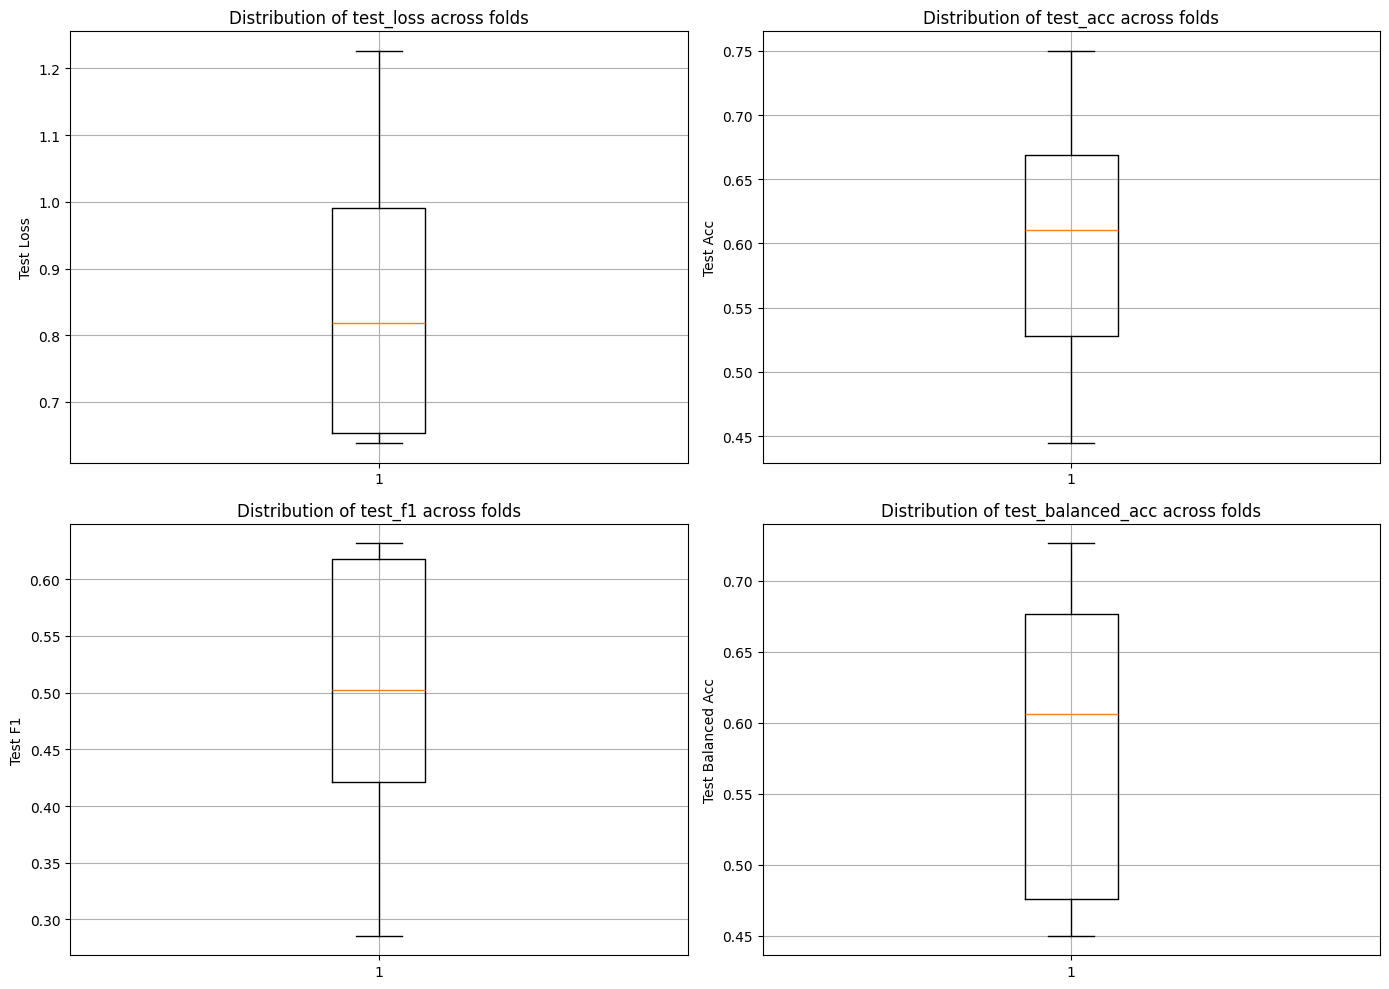

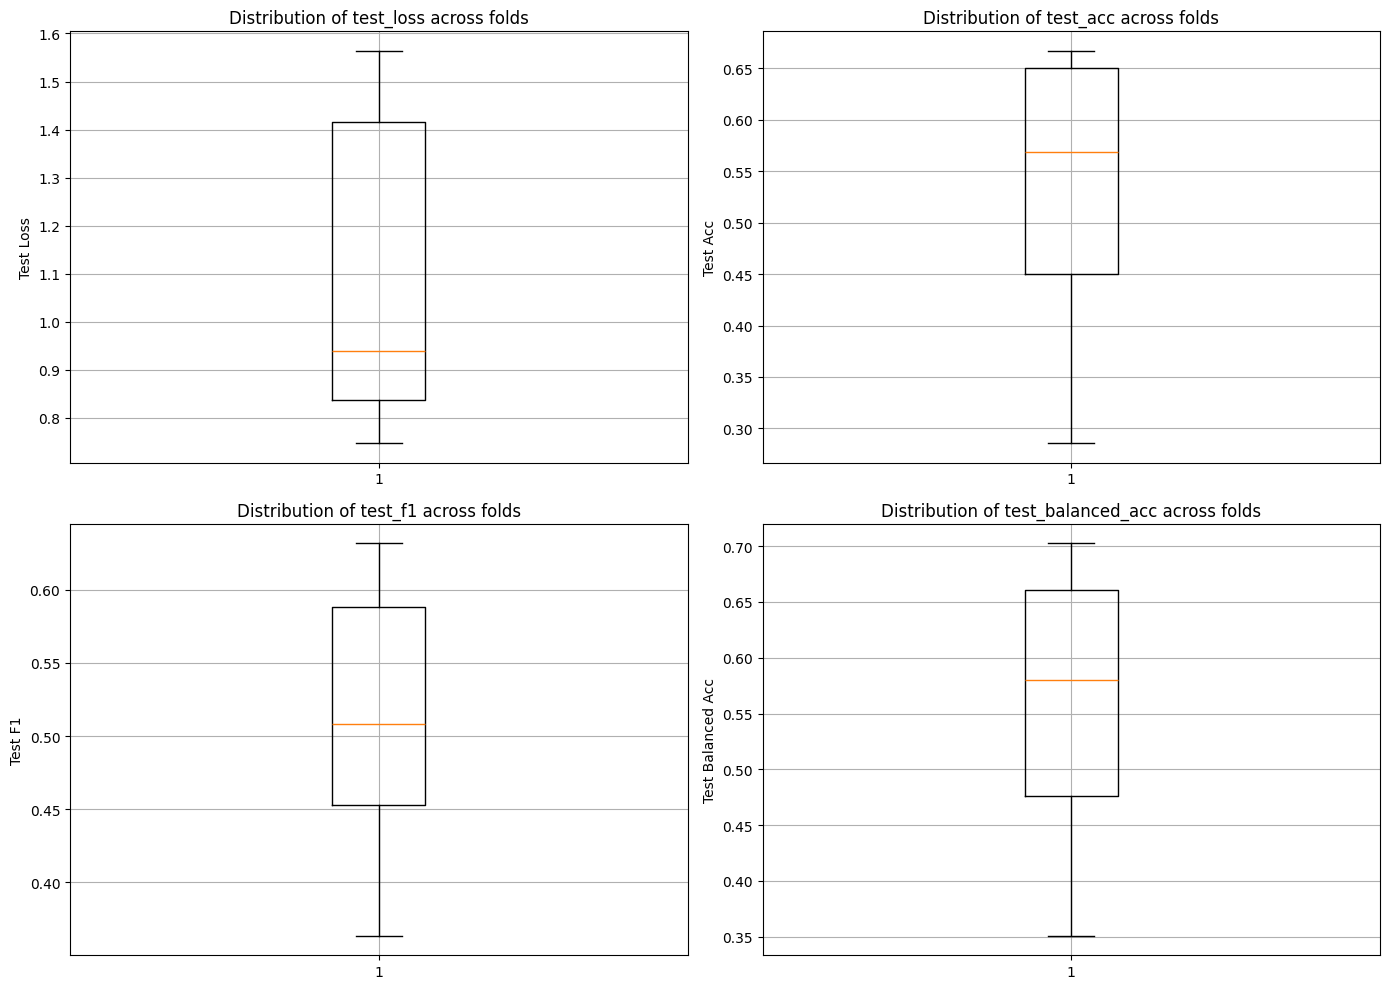

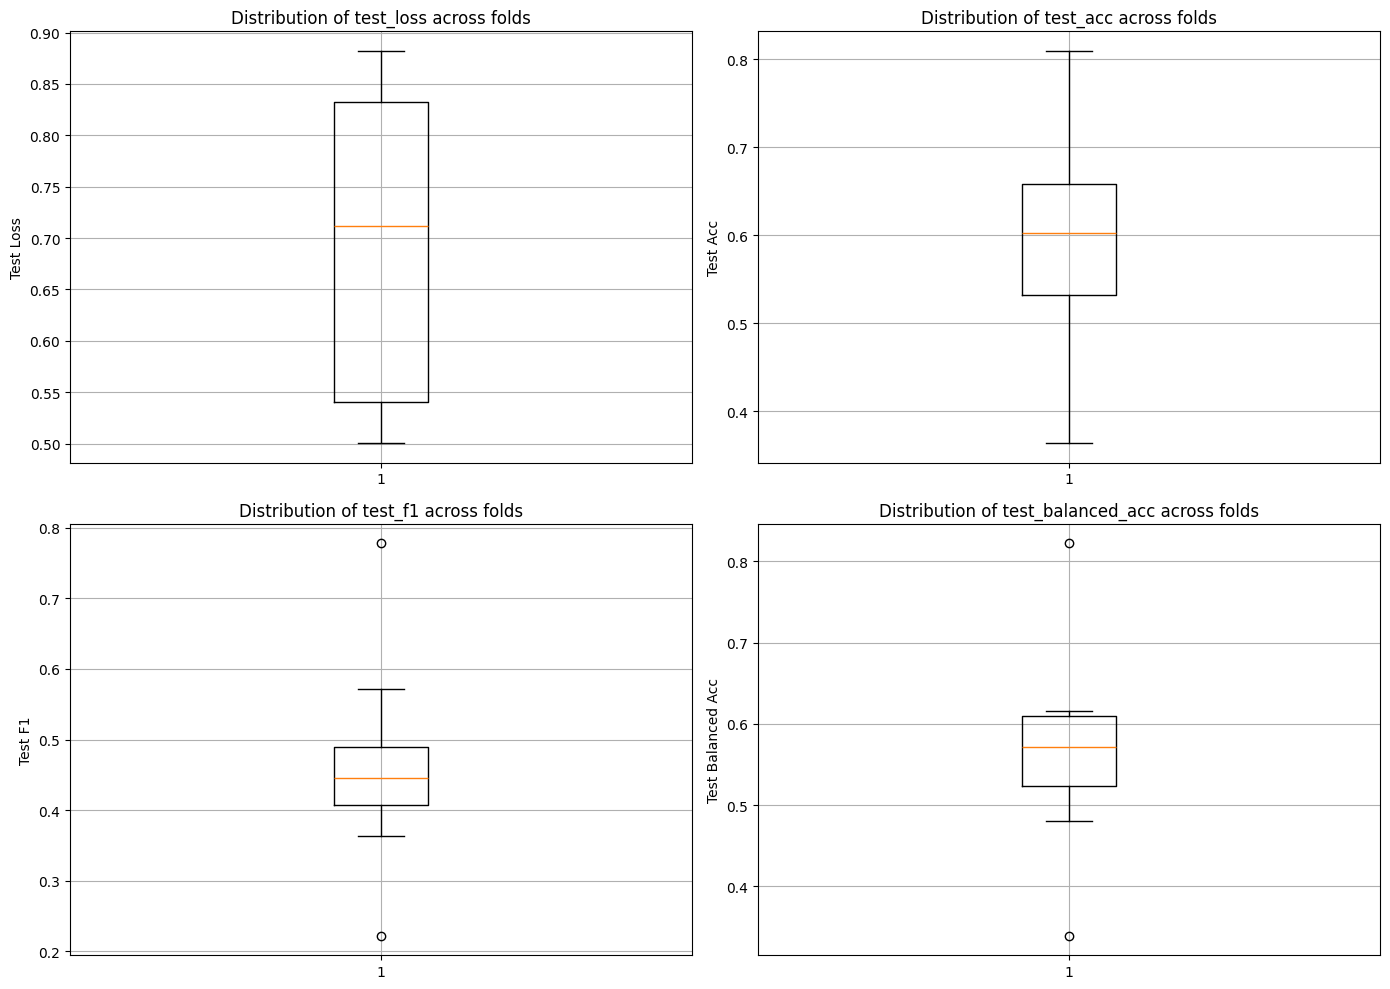

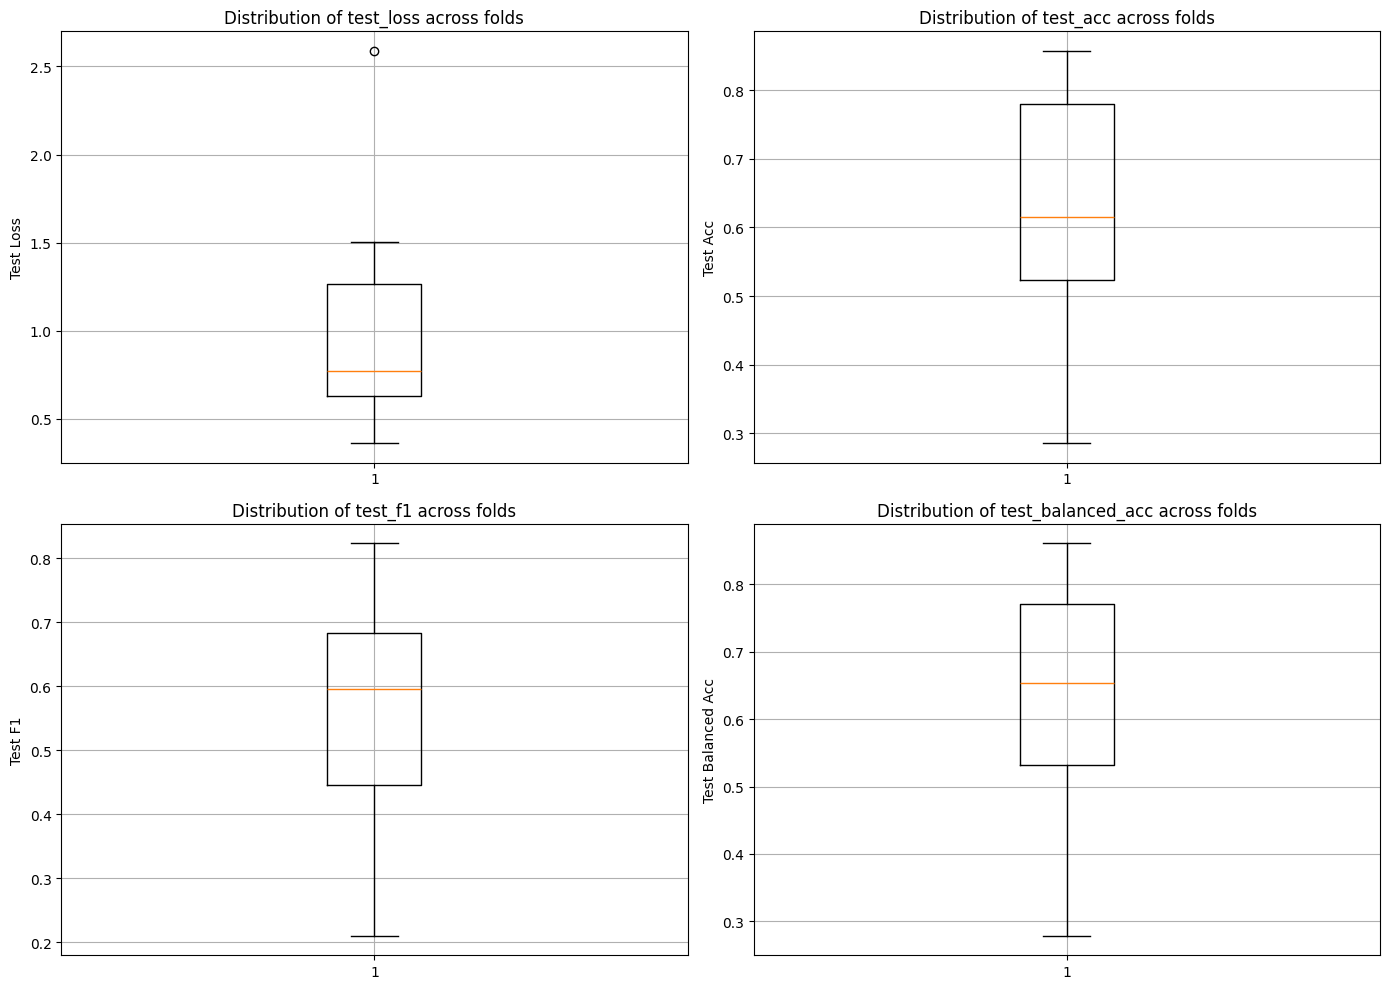

In [49]:
import utils.transformations_functions as tf
from configs.ConfigLoader import ConfigLoader
from classes.ModelManager import ModelManager
import time
# Flags ####################
transfer_learning_flag = True
########################################
available_models = ["densenet121","densenet169","resnet18","resnet50"]
color_flag = False
libraries = ["torchvision"]
pretrained_weights_list = ["imagenet"] #!TODO use , "imagenet-microscopynet"
# pretrained_weights = None #"imagenet-microscopynet"
# cfg.set_batch_size(16)
# cfg.set_freezed_layer_index(None)

config_base_path = "/home/zano/Documents/TESI/FOLDER_CINECA/configs/pretrained" if transfer_learning_flag else "/home/zano/Documents/TESI/FOLDER_CINECA/configs/3c"
for model_name in available_models:
    for pretrained_weights in pretrained_weights_list:
        for library in libraries:
            # yaml_path = f"/home/zano/Documents/TESI/FOLDER_CINECA/configs/{num_input_channels}c/{model_name}.yaml"
            yaml_path = f"{config_base_path}/{model_name}.yaml"
            cfg = ConfigLoader(yaml_path) 
            cfg.set_transfer_learning(transfer_learning_flag)
            transfer_learning = cfg.get_transfer_learning()
            # if model_name == "densenet121":
            #     cfg.set_freezed_layer_index(236)
            # pretrained if needed
            # pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
            # set the model library
            # model_library = "torchvision" # or "torchvision" or "monai"
            # color_transforms = False
            # train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=use_color_transform)
            num_channels       = cfg.get_model_input_channels()
            pretrained_weights = cfg.get_pretrained_weights()
            num_epochs         = cfg.get_num_epochs()
            num_workers        = cfg.get_num_workers()
            batch_size         = cfg.get_batch_size()
            num_folds          = cfg.get_num_folds()
            model_library      = library
            DATA_ROOT          = get_data_directory(num_channels)
            model_manager = ModelManager(cfg, library=library)
            # Verify the number of unique labels in the dataset
            num_classes = len(np.unique(train_labels_np))
            print(f"Number of classes in the dataset: {num_classes}")
            using_cosine_scheduler = False
            train_transforms, val_transforms, test_transforms = tf.get_transforms(
                cfg, color_transforms=False
            )
            # Ensure the model's output matches the number of classes
            model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

            # print(model)

            from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
            # cfg.set_freezed_layer_index(None)
            experiment = NestedCVStratifiedByPatient(
                df=df,
                cfg=cfg,
                labels_np=labels,
                pat_labels=pat_labels,
                unique_pat_ids=unique_pats,
                pretrained_weights=pretrained_weights,
                class_names=class_names,
                model_manager=model_manager,
                num_folds=num_folds,
            )
            start_time = time.time()
            train_metrics, test_results = experiment.run_experiment()

            execution_time = time.time() - start_time
            # hold_out_cv = True
            # using_cosine_scheduler = False

            train_counts, val_counts = experiment.get_early_stopping_split_counts()
            test_counts = experiment.num_outer_images

            from utils.mlflow_functions import log_SSL_run_to_mlflow

            best_idx   = best_fold_idx(test_results)
            best_model, _ = experiment._get_model_and_device()
            best_model.load_state_dict(
                torch.load(f"best_model_fold_{best_idx}.pth", map_location=device))
            best_model.eval()

            log_SSL_run_to_mlflow(
                cfg=cfg,
                model=best_model,
                class_names=class_names,
                fold_results=test_results,
                per_fold_metrics=train_metrics,
                test_transforms=val_transforms,            
                test_images_paths_np=te_imgs,
                test_true_labels_np=te_y,
                yaml_path=yaml_path,
                color_transforms=False,
                model_library=model_library,
                pretrained_weights=pretrained_weights,
                execution_time=execution_time,
                train_counts=train_counts,
                val_counts=val_counts,
                test_counts=test_counts,
            )